# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [69]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM

In [70]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [71]:
train_x = np.linspace(0, 1, 58)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [72]:
train_x.shape, train_y.shape

((58,), (58, 3))

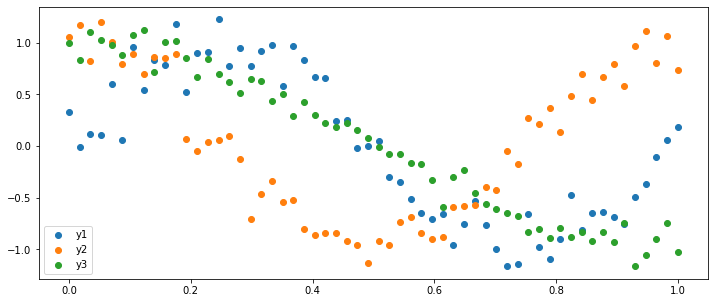

In [73]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [74]:
train_x.shape, train_y.shape

((58,), (58, 3))

In [75]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 58)

In [76]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((58, 1), (174, 2), (174, 1))

### ICM

In [77]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=3, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])    

    icm = ICM(input_dim=2, active_dims=[1], num_outputs=3, kernel=cov)
    
    sigma = pm.HalfNormal("sigma", sigma=5)
    gp = pm.gp.Marginal(cov_func=icm())
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [78]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ICM_W, ICM_kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 90 seconds.


CPU times: user 4min 26s, sys: 7min 26s, total: 11min 52s
Wall time: 1min 34s


In [79]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [80]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

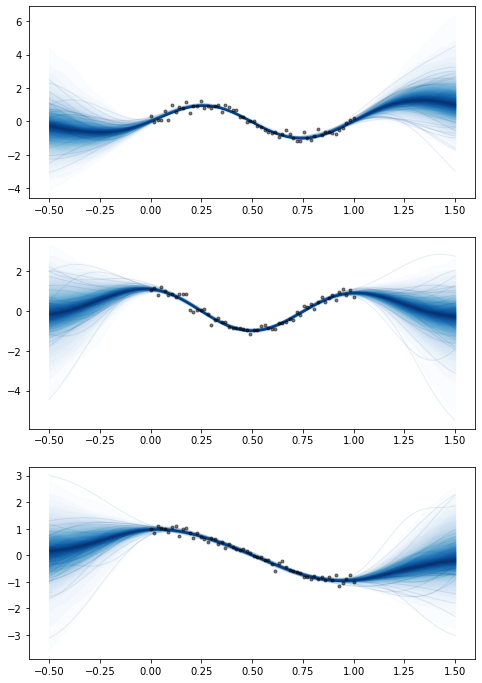

In [81]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [82]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_W[0, 0]",0.070,3.179,-5.754,5.585,0.191,0.135,271.0,333.0,NaN
"ICM_W[1, 0]",-0.064,2.630,-4.720,4.853,0.129,0.118,434.0,221.0,NaN
"ICM_W[2, 0]",-0.035,1.915,-3.494,3.121,0.086,0.094,436.0,177.0,NaN
ell,0.346,0.046,0.270,0.440,0.003,0.002,189.0,236.0,NaN
eta,0.535,0.206,0.237,0.901,0.016,0.011,202.0,277.0,NaN
ICM_kappa[0],5.409,2.282,1.647,9.507,0.108,0.076,342.0,144.0,NaN
ICM_kappa[1],5.590,2.414,1.864,9.754,0.091,0.070,688.0,253.0,NaN
ICM_kappa[2],4.001,1.744,1.119,7.356,0.062,0.045,745.0,437.0,NaN
sigma,0.159,0.009,0.142,0.176,0.000,0.000,493.0,283.0,NaN


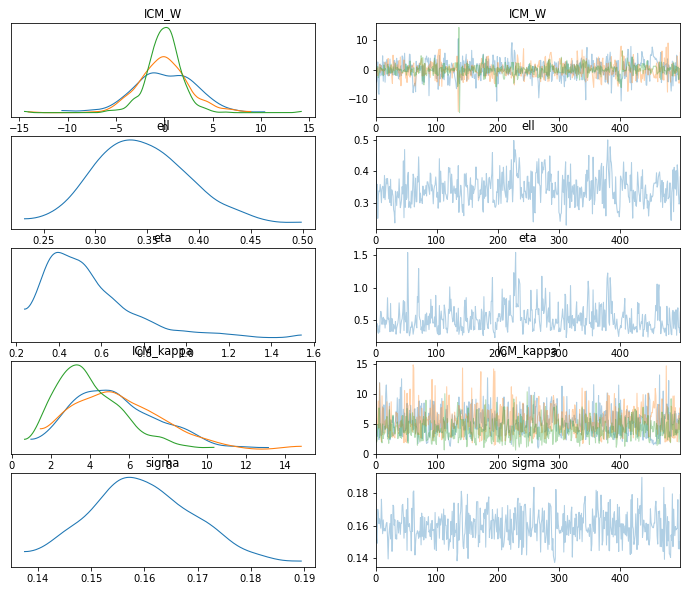

In [83]:
az.plot_trace(gp_trace);

### LCM

In [84]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=2, beta=0.5)
    cov2 = eta2**2 * pm.gp.cov.Matern32(2, ls=ell2, active_dims=[0])
    
    
    lcm = LCM(input_dim=2, active_dims=[1], num_outputs=3, kernel_list=[cov, cov2])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=lcm())
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [85]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, ICM_0_W, ICM_0_kappa, ICM_1_W, ICM_1_kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 204 seconds.


CPU times: user 9min 41s, sys: 17min 21s, total: 27min 2s
Wall time: 3min 31s


In [86]:
n_points = 200
x_new = np.linspace(-0.5, 1.5, n_points)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [87]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

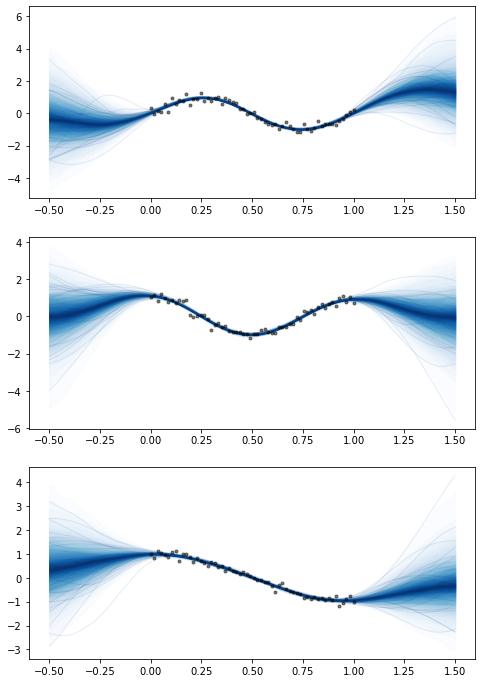

In [88]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [89]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",0.106,3.363,-5.910,6.994,0.192,0.164,312.0,266.0,NaN
"ICM_0_W[1, 0]",0.103,2.889,-5.187,5.969,0.165,0.128,318.0,208.0,NaN
"ICM_0_W[2, 0]",-0.116,1.760,-3.816,2.712,0.093,0.084,371.0,266.0,NaN
"ICM_1_W[0, 0]",0.271,4.716,-7.747,9.523,0.198,0.220,567.0,340.0,NaN
"ICM_1_W[1, 0]",-0.167,4.148,-8.830,6.843,0.188,0.170,462.0,401.0,NaN
"ICM_1_W[2, 0]",-0.297,3.708,-7.695,6.623,0.168,0.169,492.0,365.0,NaN
ell,0.347,0.051,0.243,0.432,0.003,0.002,311.0,267.0,NaN
eta,0.532,0.205,0.222,0.909,0.012,0.009,282.0,382.0,NaN
ell2,4.654,2.963,0.332,9.959,0.157,0.113,286.0,149.0,NaN
eta2,0.432,0.373,0.034,1.047,0.017,0.012,557.0,473.0,NaN


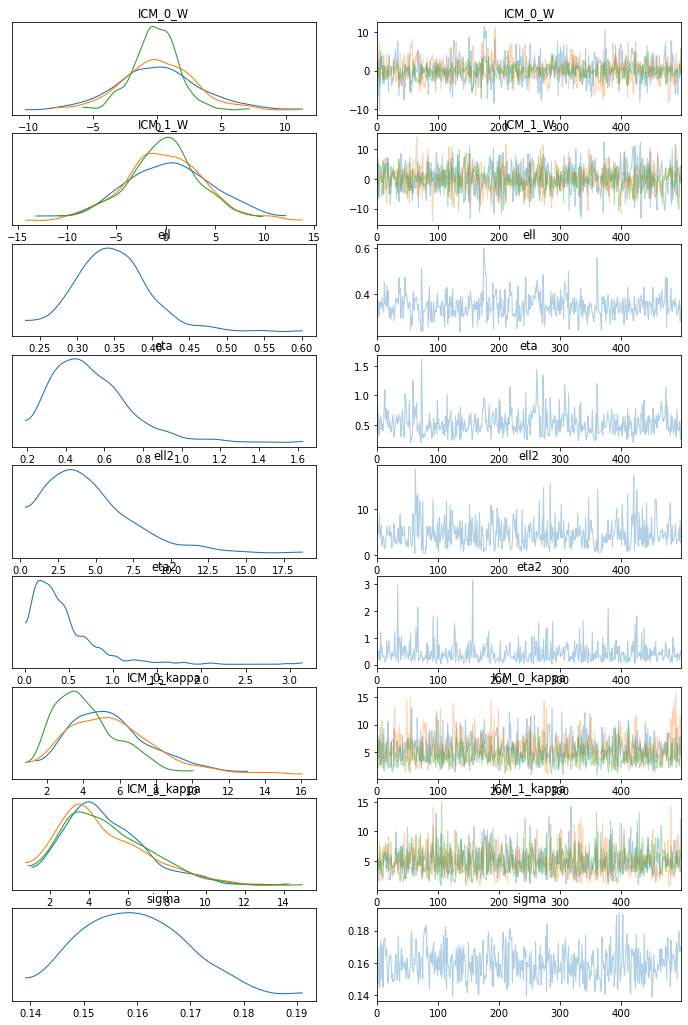

In [90]:
az.plot_trace(gp_trace);